# Improved Image Segmentation Model

This notebook implements an improved image segmentation model using Keras. The steps include loading and preprocessing images, building the model, training, and evaluating its performance.

# 1. Import Libraries

In [1]:
# Importing essential libraries for image processing, deep learning, and file handling
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import LogNorm

# TensorFlow and Keras for building the neural network model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

import json

# 2. Define Helper Functions

## 2.1 Loading and pre-processing images

In [2]:
# Function to load an image from a given file path
def load_image(image_path):
    """
    Opens an image and converts it to a numpy array.
    Args:
    - image_path (str): Path to the image file.
    Returns:
    - np.array: Image as a numpy array.
    """
    img = Image.open(image_path)  # Load image
    img_array = np.array(img)  # Convert image to numpy array
    return img_array

# Function to extract the numerical part from filenames
# This helps ensure images are loaded in the correct order
def extract_number(filename):
    """
    Extracts and returns the numeric part from a filename.
    Args:
    - filename (str): The filename containing numbers.
    Returns:
    - int: Extracted numeric part.
    """
    return int(''.join(filter(str.isdigit, filename)))

# Function to normalize image pixel values between 0 and 1
def normalize_images(images):
    """
    Normalizes images by dividing pixel values by 255.
    Args:
    - images (np.array): Array of images.
    Returns:
    - np.array: Normalized images.
    """
    return images / 255.0

# Function to binarize labels to 0 or 1
def binarize_labels(labels):
    """
    Converts labels to binary values (0 or 1) based on intensity.
    Args:
    - labels (np.array): Array of labels.
    Returns:
    - np.array: Binarized labels as floats.
    """
    return (labels > 0).astype(np.float32)

## 2.2 Calculate Accuracy Metrics

In [3]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(y_true, y_pred):
    """
    Calculates the Intersection over Union (IoU) for a batch of predicted and true labels.
    IoU is a measure of the overlap between predicted and ground truth labels.

    Args:
    - y_true (np.array): Ground truth labels.
    - y_pred (np.array): Predicted labels.

    Returns:
    - float: IoU value.
    """
    # Case where both the ground truth and the prediction are all black
    if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
        return 1.0  # 100% IoU for all black images

    # True Positives (TP): Predicted 1 and Ground Truth is 1
    TP = np.sum((y_true == 1) & (y_pred == 1))
    
    # False Positives (FP): Predicted 1 and Ground Truth is 0
    FP = np.sum((y_true == 0) & (y_pred == 1))
    
    # False Negatives (FN): Predicted 0 and Ground Truth is 1
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Compute IoU
    union = TP + FP + FN
    if union == 0:
        return 0.0  # In case there are no positives or predictions at all
    
    iou = TP / union
    return iou


## 2.3 Visualization Functions

In [4]:
# Function to plot images, ground truth labels, and predictions in a grid
def plot_images(images, labels, predictions=None, num=10):
    """
    Plots a grid of images, ground truth labels, and optionally, predictions.
    
    Args:
    - images (np.array): Array of images to be displayed.
    - labels (np.array): Array of ground truth labels corresponding to the images.
    - predictions (np.array, optional): Array of predicted labels. If not provided, only images and labels are displayed.
    - num (int): Number of images to display in the grid. Default is 10.
    
    The function displays:
    - The original images in the first row.
    - The corresponding ground truth labels in the second row.
    - The predicted labels (if provided) in the third row.
    """
    
    # Set the figure size to accommodate the grid of images
    plt.figure(figsize=(8, 5))
    
    for i in range(num):
        # Select an index for the image, label, and prediction (if available)
        # The default behavior is to take images from 0 to num-1
        idx = i
        
        # Plot the original image
        plt.subplot(3, num, i + 1)  # First row for images
        plt.imshow(images[idx].squeeze(), cmap='gray')  # Use squeeze to remove any singleton dimensions
        plt.title("Image")  # Title for the original image
        plt.axis('off')  # Turn off axis labels for clarity
        
        # Plot the ground truth label
        plt.subplot(3, num, num + i + 1)  # Second row for ground truth labels
        plt.imshow(labels[idx].squeeze(), cmap='gray')  # Display the label image
        plt.title("Ground Truth")  # Title for the ground truth image
        plt.axis('off')  # Turn off axis labels for clarity
        
        # Plot the predicted label, if predictions are provided
        if predictions is not None:
            plt.subplot(3, num, 2 * num + i + 1)  # Third row for predicted labels
            plt.imshow(predictions[idx].squeeze(), cmap='gray')  # Display the prediction image
            plt.title("Prediction")  # Title for the predicted image
            plt.axis('off')  # Turn off axis labels for clarity
    
    # Adjust spacing between the plots for better layout
    plt.tight_layout()


In [5]:
def calculate_confusion_matrix(y_test, y_pred):
    """
    Calculate the total TP, FP, TN, FN for the entire dataset.
    """
    # Flatten all masks
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate confusion matrix components
    tp = np.sum((y_test_flat == 1) & (y_pred_flat == 1))
    tn = np.sum((y_test_flat == 0) & (y_pred_flat == 0))
    fp = np.sum((y_test_flat == 0) & (y_pred_flat == 1))
    fn = np.sum((y_test_flat == 1) & (y_pred_flat == 0))
    
    return tp, fp, tn, fn

def plot_confusion_matrix(tp, fp, tn, fn):
    """
    Plot a confusion matrix for the segmentation results with a log-scaled color bar.
    """
    cm = np.array([[tn, fp],
                   [fn, tp]])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    heatmap = sns.heatmap(cm, annot=True, fmt='0.3e', cmap='Blues', 
                          norm=LogNorm(), 
                          xticklabels=['Background', 'Particle'], 
                          yticklabels=['Background', 'Particle'])
    
    # Label axes and color bar
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_label('Total Number of Pixels in Test Set', rotation=270, labelpad=20)
    


# 3. Create Improved Model Architecture

In [6]:
# Define the improved convolutional neural network (CNN) model
def improved_nn(input_shape, kernel_size=6):
    """
    Improved neural network for image segmentation with deeper architecture and transpose convolution layers.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        kernel_size (int): Size of the kernel (default is 6).

    Returns:
        model: A compiled Keras Sequential model ready for training.
    
    Model Architecture:
        - Input: Takes images with shape defined by 'input_shape'.
        - Conv2D: First convolutional layer with 32 filters, ReLU activation, 
                  'same' padding, and kernel size defined by 'kernel_size'.
        - MaxPooling2D: Pooling layer to downsample the feature maps by a factor of 2.
        - Conv2D: Second convolutional layer with 64 filters, ReLU activation, 
                  'same' padding, and kernel size defined by 'kernel_size'.
        - MaxPooling2D: Pooling layer to downsample the feature maps by a factor of 2.
        - Conv2D: Third convolutional layer with 128 filters, ReLU activation, 
                  'same' padding, and kernel size defined by 'kernel_size'.
        - MaxPooling2D: Pooling layer to downsample the feature maps by a factor of 2.
        - Conv2D: Fourth convolutional layer with 256 filters, ReLU activation, 
                  'same' padding, and kernel size defined by 'kernel_size'.
        - Conv2DTranspose: Transpose convolutional layers to upsample the feature maps back to the original size.
        - Conv2D: Final convolutional layer with 1 filter, sigmoid activation for pixel-wise 
                  binary classification (1 output channel for binary segmentation).
        - Output: A binary mask with the same height and width as the input image.
        
    Compilation:
        - Optimizer: Adam.
        - Loss: Binary Crossentropy (used for binary classification).
        - Metrics: Accuracy.
    """
    
    # Initialize the sequential model
    model = models.Sequential()
    
    # Add the first convolutional layer
    # - 32 filters for feature extraction
    # - Kernel size defined by 'kernel_size'
    # - Activation: ReLU to introduce non-linearity
    # - Padding: 'same' ensures the output size matches the input size
    # - Input shape: Defines the shape of the input images (height, width, channels)
    model.add(layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=input_shape))
    
    # Downsample using MaxPooling (factor of 2)
    # - Reduces the spatial dimensions of the feature maps by a factor of 2
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Add the second convolutional layer
    # - 64 filters for learning more complex features
    # - Kernel size defined by 'kernel_size'
    # - Activation: ReLU for non-linearity
    # - Padding: 'same' keeps spatial dimensions consistent
    model.add(layers.Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same'))
    
    # Downsample again using MaxPooling (factor of 2)
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Add the third convolutional layer
    # - 128 filters for deeper feature extraction
    # - Kernel size defined by 'kernel_size'
    model.add(layers.Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same'))
    
    # Downsample again using MaxPooling (factor of 2)
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Add the fourth convolutional layer
    # - 256 filters for even more complex features
    # - Kernel size defined by 'kernel_size'
    model.add(layers.Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same'))
    
    # Add the first transpose convolutional layer for upsampling
    # - 128 filters to match the previous number of filters before downsampling
    # - Kernel size defined by 'kernel_size'
    # - Strides of (2, 2) to upsample the spatial dimensions by a factor of 2
    model.add(layers.Conv2DTranspose(128, (kernel_size, kernel_size), strides=(2, 2), padding='same'))
    
    # Add the second transpose convolutional layer for upsampling
    # - 64 filters to match the previous number of filters before downsampling
    model.add(layers.Conv2DTranspose(64, (kernel_size, kernel_size), strides=(2, 2), padding='same'))
    
    # Add the third transpose convolutional layer for upsampling
    # - 32 filters to match the initial number of filters
    model.add(layers.Conv2DTranspose(32, (kernel_size, kernel_size), strides=(2, 2), padding='same'))
    
    # Add the final convolutional layer for pixel-wise classification
    # - 1 filter for binary segmentation (output channel for mask prediction)
    # - Kernel size is (1, 1) to output a single pixel value per position
    # - Activation function: Sigmoid to produce probabilities between 0 and 1
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))
    
    # Compile the model
    # - Optimizer: Adam, a popular optimizer for training neural networks
    # - Loss: Binary cross-entropy, suitable for binary classification tasks
    # - Metrics: Accuracy to monitor the percentage of correctly classified pixels
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


# 4. Load Images and Labels

In [7]:
# Set paths to the images and labels folders 
# These paths should point to the directories containing the images and labels for segmentation
images_path = 'unet_dataset_resized\\images'
labels_path = 'unet_dataset_resized\\labels'

# Initialize lists to store loaded images (X) and labels (y)
X = []
y = []

# List and sort files numerically based on extracted numbers in filenames
# This ensures that images and their corresponding labels match up correctly
image_files = sorted(os.listdir(images_path), key=extract_number)
label_files = sorted(os.listdir(labels_path), key=extract_number)

# Loop through the paired image and label filenames
for image_filename, label_filename in zip(image_files, label_files):
    # Construct full file paths for the current image and label
    image_file = os.path.join(images_path, image_filename)
    label_file = os.path.join(labels_path, label_filename)

    # Load the image and label using the predefined load_image function
    image = load_image(image_file)
    label = load_image(label_file)

    # Append the loaded image and label to their respective lists
    X.append(image)
    y.append(label)

# Convert the lists of images and labels to Numpy arrays for efficient processing
X = np.array(X)
y = np.array(y)

# Print the shapes of the features (X) and labels (y) to verify they were loaded correctly
# X.shape[0] is the number of images, and X.shape[1] and X.shape[2] are the image dimensions
print(f"Shape of X (features): {X.shape} i.e. {X.shape[0]} images with dimensions {X.shape[1]}x{X.shape[2]} pixels")
print(f"Shape of y (labels): {y.shape} i.e. {y.shape[0]} labels with dimensions {y.shape[1]}x{y.shape[2]} pixels")

# Reshape X and y to add a channel dimension (since the images are grayscale, this is 1)
# The shape becomes (N, D, D, 1) where N is the number of images, D is the image dimension
X = X[..., np.newaxis]
y = y[..., np.newaxis]

# Normalize the image pixel values to be between 0 and 1 and binarize the labels
X = normalize_images(X)  # Divide by 255.0 for normalization
y = binarize_labels(y)   # Convert labels to binary values (0 or 1)

# Shuffle the images and labels together to randomize the dataset order
np.random.seed(42)  # Set a random seed for reproducibility
indices = np.arange(X.shape[0])  # Generate an array of indices based on the number of images
np.random.shuffle(indices)  # Shuffle the indices randomly
X = X[indices]  # Reorder X using the shuffled indices
y = y[indices]  # Reorder y using the same shuffled indices

# Set aside the first 20 percent of the already shuffled images and labels as a separate test set
X_test = X[:int(X.shape[0]*0.2)]
y_test = y[:int(y.shape[0]*0.2)]
X = X[int(X.shape[0]*0.2):]  # Remaining images for training/validation
y = y[int(y.shape[0]*0.2):]

# Perform a train-test split on the remaining dataset to create training and validation sets
# 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training, validation, and test sets to verify they are split correctly
print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")


Shape of X (features): (100, 256, 256) i.e. 100 images with dimensions 256x256 pixels
Shape of y (labels): (100, 256, 256) i.e. 100 labels with dimensions 256x256 pixels
Shape of X_train: (64, 256, 256, 1), y_train: (64, 256, 256, 1)
Shape of X_val: (16, 256, 256, 1), y_val: (16, 256, 256, 1)
Shape of X_test: (20, 256, 256, 1), y_test: (20, 256, 256, 1)


# 5. Model Training

In [10]:
# Initiate the model
model = improved_nn((256, 256, 1))

# Print the summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      1184      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

In [11]:
# Define the ModelCheckpoint callback to save the best model based on validation loss
# - 'improved_model.keras' is the file name where the best model will be saved.
# - 'monitor' parameter specifies the metric to monitor ('val_loss' in this case).
# - 'save_best_only=True' ensures that only the model with the lowest validation loss is saved.
# - 'mode' set to 'min' indicates that the goal is to minimize 'val_loss'.
# - 'verbose=1' prints a message each time the model is saved, providing updates during training.
checkpoint = ModelCheckpoint('improved_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model and capture the training history
# - X_train and y_train are the training data and labels.
# - 'epochs' is set to 20, meaning the model will train for 20 full passes through the training data.
# - 'batch_size' of 32 means the model updates weights after every 32 samples.
# - 'validation_data' provides the validation set (X_val, y_val) to evaluate performance after each epoch.
# - 'callbacks' include the ModelCheckpoint callback to save the best model during training.
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

# Save the training history to a JSON file
# - The training history (loss, accuracy, etc.) is stored in 'history.history'.
# - Opening a file named 'improved_model_training_history.json' to write this data.
# - 'json.dump' saves the history data in JSON format for later analysis or plotting.
with open('improved_model_training_history.json', 'w') as f:
    json.dump(history.history, f)


Epoch 1/10


2024-10-28 13:09:36.170327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-10-28 13:09:36.468390: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-28 13:09:39.319734: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3cde2f5b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 13:09:39.319828: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-10-28 13:09:39.319837: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-10-28 13:09:39.319846: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
2024-10-28 13:09:39.319853: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3

80/80 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9815
Epoch 1: val_loss improved from inf to 0.04555, saving model to improved_model.keras
80/80 [==============================] - 25s 111ms/step - loss: 0.0820 - accuracy: 0.9815 - val_loss: 0.0455 - val_accuracy: 0.9888
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9945
Epoch 2: val_loss improved from 0.04555 to 0.00841, saving model to improved_model.keras
80/80 [==============================] - 8s 94ms/step - loss: 0.0206 - accuracy: 0.9945 - val_loss: 0.0084 - val_accuracy: 0.9971
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9972
Epoch 3: val_loss improved from 0.00841 to 0.00702, saving model to improved_model.keras
80/80 [==============================] - 7s 91ms/step - loss: 0.0079 - accuracy: 0.9972 - val_loss: 0.0070 - val_accuracy: 0.9974
Epoch 4/10
80/80 [==============================] - ETA: 0s - loss: 0.0067

In [8]:
# Load the best saved model
model = load_model('improved_model.keras')

2024-10-30 14:10:44.251397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 14:10:48.671159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44442 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-10-30 14:10:48.674074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46639 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:23:00.0, compute capability: 8.6
2024-10-30 14:10:48.676093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

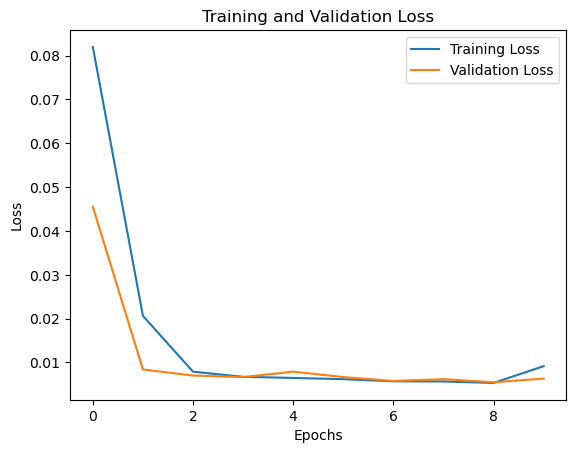

In [9]:
# Load the saved history
with open('improved_model_training_history.json', 'r') as f:
    history = json.load(f)

# Plot the training and validation loss curves
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Model Evaluation on Test Set

## 6.1 Test Set Accuracy

The first accuracy metric is calculated as the number of correctly predicted pixels divided by the total number of pixels. For our dataset, the simple accuracy metric is not a great indicator of performance because of the small size of the particles relative to the background.

This metric calculates the percentage of correctly classified pixels (particle or background) over the entire test set. It provides a general measure of the model's ability to classify each pixel correctly. However, it does not account for how well the predicted mask aligns with the shape and size of the ground truth objects. In segmentation tasks where class imbalance is common (e.g., background pixels far outnumber particle pixels), the accuracy can be misleadingly high.

In [10]:
# Evaluate the model on the test set and capture the loss and accuracy
# - X_test and y_test are the test data and labels.
# - 'evaluate' returns the loss and accuracy on the test set.
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}")

2024-10-30 14:10:50.244262: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-10-30 14:10:50.329794: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


25/25 [==============================] - 2s 19ms/step - loss: 0.0051 - accuracy: 0.9979
Test loss: 0.005148523487150669, Test accuracy: 0.9979326725006104


## 6.2 Test Set Intersection over Union

IoU is a more precise metric for evaluating image segmentation performance for our use case. It measures the overlap between the predicted mask and the ground truth mask, considering both the correctly predicted areas and the misclassified ones. IoU is particularly useful in our use case because it penalizes false positives (extra predicted regions) and false negatives (missed regions), providing a better assessment of model performance compared when particle pixels are much fewer than background pixels

In [11]:
# Get the model's predictions for the test set
# - 'predict' generates predicted masks for each image in X_test.
y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary masks (0 or 1)
# - A threshold of 0.5 is used; values above 0.5 are set to 1, others to 0.
# - This is necessary for binary classification, where pixel values must be either 0 or 1.
y_pred = (y_pred > 0.5).astype(np.uint8)

# Calculate the Intersection over Union (IoU) for all test samples
ious = []  # Initialize a list to store IoU values for each test sample
for i in range(len(X_test)):
    # 'calculate_iou' computes the IoU between the ground truth (y_test[i]) and predicted mask (y_pred[i])
    iou = calculate_iou(y_test[i], y_pred[i])
    ious.append(iou)  # Append the IoU value to the list

# Calculate the average IoU across all test samples
average_iou = np.mean(ious)  # Mean of the IoU values
print(f"Average IoU: {average_iou}")


25/25 [==============================] - 1s 18ms/step
Average IoU: 0.9088446166760943


## 6.3 Visualizing Model Performance

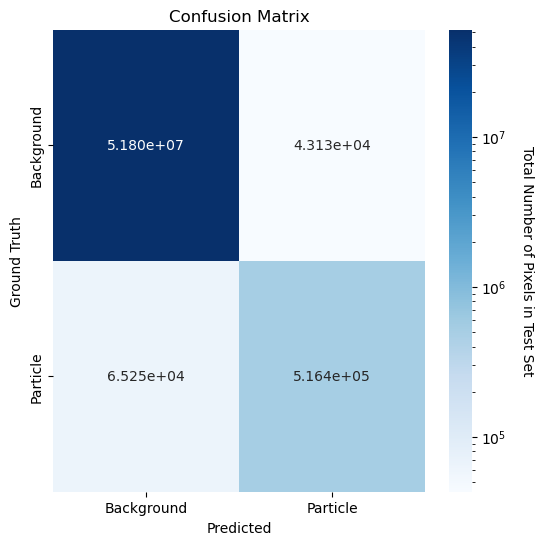

In [43]:
# Visualizing the Confusion Matrix for the Model's Performance

# Calculate the confusion matrix elements: True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
# - y_test: Ground truth binary masks for the test set.
# - y_pred: Predicted binary masks for the test set generated by the model.
# - The function 'calculate_confusion_matrix' should return the counts of TP, FP, TN, and FN for each image in the dataset.
tp, fp, tn, fn = calculate_confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using the function 'plot_confusion_matrix'
# - tp: True Positives, pixels correctly identified as part of the object (particle).
# - fp: False Positives, pixels incorrectly identified as part of the object (should be background).
# - tn: True Negatives, pixels correctly identified as background.
# - fn: False Negatives, pixels incorrectly identified as background (should be part of the object).
# The function 'plot_confusion_matrix' should create a visual representation (e.g., a heatmap) to illustrate these values.
plot_confusion_matrix(tp, fp, tn, fn)


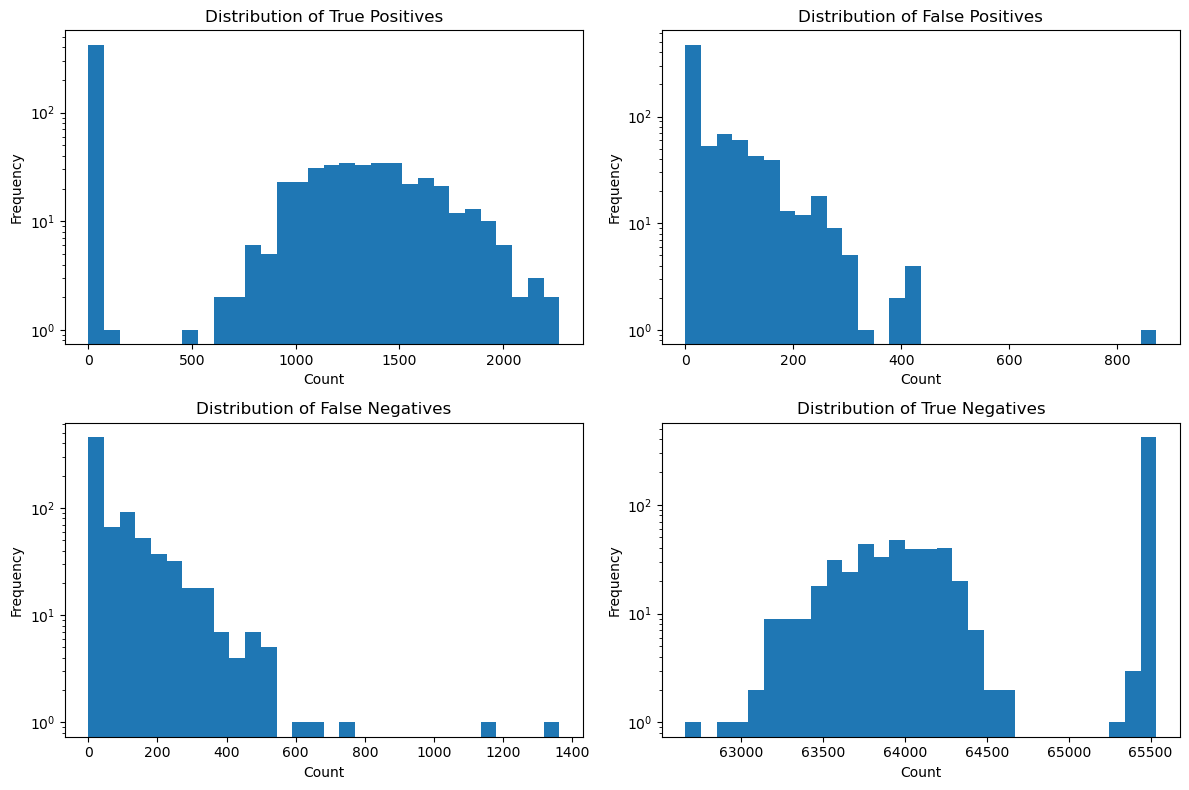

In [41]:
# Visualize the distribution of TPs, FPs, FNs, and FPs across images in the dataset
# initialize lists to store TP, FP, FN, TN for each image
TP_list = []
FP_list = []
FN_list = []
TN_list = []

# loop through each image
for y_test_i, y_pred_i in zip(y_test, y_pred):
    # calculate TP, FP, TN, FN for the current image
    TP, FP, TN, FN = calculate_confusion_matrix(y_test_i, y_pred_i)
    
    # append to the lists
    TP_list.append(TP)
    FP_list.append(FP)
    FN_list.append(FN)
    TN_list.append(TN)

# plot histograms for distributiosn for each parameter
plt.figure(figsize=(12,8))
# plt.suptitle(f'Distribution of TP, FP, FN, and TN over {y_test.shape[0]} test images', fontsize=16)
labels = ["True Positives", "False Positives", "False Negatives", "True Negatives"]
data = [TP_list, FP_list, FN_list, TN_list]
for i, label in enumerate(labels):
    plt.subplot(2, 2, i+1)
    plt.hist(data[i],bins=30)
    plt.title(f'Distribution of {label}')
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.semilogy()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 94ms/step


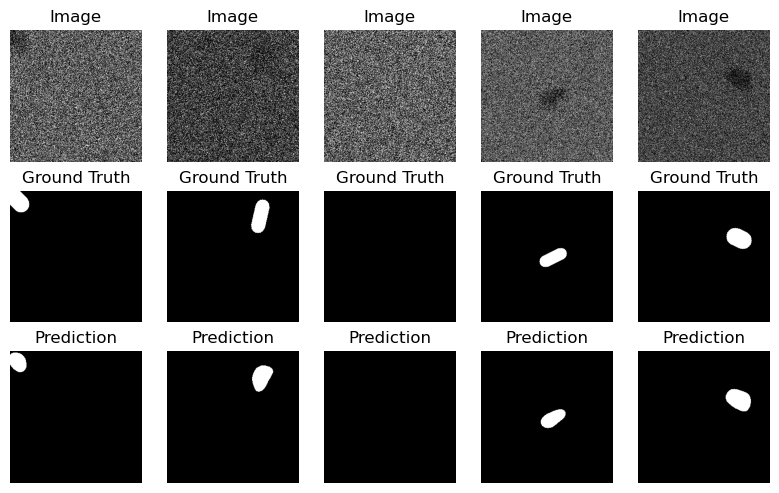

In [ ]:
# Visualizing Test Set predicted masks

# Set the random seed for reproducibility
np.random.seed(53)

# Define the number of test images to display for visualization
num_images_to_display = 5

# Randomly choose 5 indices from the test set without replacement
random_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

# Select the randomly chosen images and their corresponding labels from the test set
test_images = X_test[random_indices]
test_labels = y_test[random_indices]

# Get the model's predictions for the selected test images
# - 'predict' generates predicted masks for each of the selected images.
predictions = model.predict(test_images)

# Binarize predictions by applying a threshold of 0.5 for binary classification
# - Values above 0.5 are set to 1 (particle), and values below are set to 0 (background).
predictions = (predictions > 0.5).astype(np.uint8)

# Visualize the test images, their ground truth labels, and the model's predictions side by side
# - 'plot_images' displays the images, labels, and predictions for easy comparison.
plot_images(test_images, test_labels, predictions,num = num_images_to_display)
